In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import GprModel
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import skgstat as skg
from skgstat import Variogram, OrdinaryKriging

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Experiment results for all 6 features (precip is removed)
# with fixed GPR model

In [18]:
plt.rcParams.update({'font.size': 16})

In [3]:
def subsample_data(data, sample_size = 10000):
    indices = np.random.choice(data.shape[0], sample_size, replace=False)
    
    return indices

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    target_scaler = StandardScaler()  
    scaled_train_y = target_scaler.fit_transform(train_y)
    scaled_test_y = target_scaler.transform(test_y)    
    
    return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

In [20]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers for GP only, other models are saved
# GPR is a interpolation method, no need to record traning data.
gpr_test_results = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        # Select the wind speed only
        flatten_train_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
        
        # Reshape the data per time stamp
        flatten_train_x_reshaped = flatten_train_x.reshape(20,-1, flatten_train_x.shape[-1])
        flatten_train_y_reshaped = flatten_train_y.reshape(20,-1, flatten_train_y.shape[-1])
        
        flatten_test_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
         # Select the wind speed only
        flatten_test_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
              
        test_results_fold = []
        
        gpr_models = []
        for i in range(0, number_of_folds):            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")
            indices = np.random.choice(flatten_train_x_reshaped.shape[1], 200, replace=False)
            
            kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
            gpr_train_x = np.vstack(flatten_train_x_reshaped[:,indices,:])
            gpr_train_y = np.vstack(flatten_train_y_reshaped[:,indices,:].reshape(-1,1))
            
            gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(gpr_train_x, gpr_train_y)
            pred = gpr_model.predict(flatten_test_x, return_std=False)
            rmse = mean_squared_error(pred, flatten_test_y, squared=False)
            test_results_fold.append({'gpr_test' : rmse})
            print(rmse)
            
        #After all folds are done, update the result containers
        gpr_test_results.append(test_results_fold)
        

In [21]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 1 stations
16.09389173680952
Currently running fold 1 for 1 stations
16.180775346303353
Currently running fold 2 for 1 stations
16.15435486573977
Currently running fold 3 for 1 stations
16.217723748844964
Currently running fold 4 for 1 stations
16.15081016136566
Currently running fold 5 for 1 stations
16.23766971793474
Currently running fold 6 for 1 stations
16.16251986353853
Currently running fold 7 for 1 stations
16.155474786180616
Currently running fold 8 for 1 stations
16.200629692956404
Currently running fold 9 for 1 stations
16.20500053174558
Currently running fold 0 for 2 stations
8.143272581692361
Currently running fold 1 for 2 stations
7.702830982632544
Currently running fold 2 for 2 stations
7.873412709944583
Currently running fold 3 for 2 stations
7.558069561992582
Currently running fold 4 for 2 stations
7.75221667723497
Currently running fold 5 for 2 stations
7.783782352335033
Currently running fold 6 for 2 stations
7.882203072744048
Currently r

In [24]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# %store gpr_matern_test_results

#closing seesion, restarting kernel

# %store -r training_results_li_ts_km_nn_full_feature
# %store -r test_results_li_ts_km_nn_full_feature

Stored 'gpr_matern_test_results' (list)


In [26]:
# gpr_test_results=[]
# gpr_test_results.append({'gpr_test': 124.28245462517742})
# gpr_test_results.append({'gpr_test': 8.098453253845573})
# gpr_test_results.append({'gpr_test': 7.383525517000387})
# gpr_test_results.append({'gpr_test': 7.266723098591452})
# gpr_test_results.append({'gpr_test': 7.269252212307546})
# gpr_test_results.append({'gpr_test': 7.246991937014375})
# gpr_test_results.append({'gpr_test': 7.127975366729728})
# gpr_test_results.append({'gpr_test': 7.125519317911804})
# gpr_test_results.append({'gpr_test': 7.096831995981307})
# gpr_test_results.append({'gpr_test': 7.09245097390881})
# gpr_test_results.append({'gpr_test': 7.123352723065476})
# gpr_test_results.append({'gpr_test': 7.136209476848252})

gar matern
16.1759±0.0393
gar matern
7.7862±0.1494
gar matern
7.2294±0.0798
gar matern
7.0857±0.0814
gar matern
6.9272±0.059
gar matern
6.9971±0.145
gar matern
7.0069±0.0662
gar matern
7.08±0.0418
gar matern
7.0796±0.0686
gar matern
7.1004±0.0794
gar matern
7.1875±0.0708
gar matern
7.1263±0.0559
exp
linear
7.2407±0.0
nn
6.235±0.0081
fcm
6.4338±0.0112
kmeans
6.480100154876709±0.020400000736117363
kmeans min
6.4517998695373535
exp
linear
7.0117±0.0
nn
5.8649±0.0073
fcm
5.9632±0.011
kmeans
22.150100708007812±48.34239959716797
kmeans min
6.016600131988525
exp
linear
6.916±0.0
nn
5.5969±0.0055
fcm
5.6758±0.0039
kmeans
31.85449981689453±73.34120178222656
kmeans min
5.743800163269043
exp
linear
6.6074±0.0
nn
5.5032±0.0077
fcm
5.5779±0.0082
kmeans
64.15029907226562±150.1374053955078
kmeans min
5.676599979400635
exp
linear
6.4329±0.0
nn
5.4698±0.0053
fcm
5.5187±0.0104
kmeans
112.33190155029297±241.3701934814453
kmeans min
5.614699840545654
exp
linear
6.4353±0.0
nn
5.4486±0.0058
fcm
5.4819±0.006

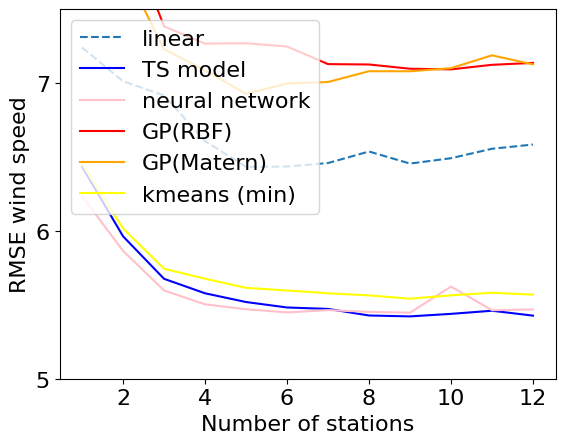

In [28]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []
gpr_matern_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results_li_ts_km_nn_full_feature:
     kmeans_train_plot.append(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(exp['gpr_test'])

for exp in gpr_matern_test_results:
    print('gar matern')
    print(f"{np.round(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]), 4)}±{np.round(np.std([d['gpr_test'] for d in exp if 'gpr_test' in d]),4)}")
    gpr_matern_test_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, gpr_test_plot, label='GP(RBF)', c='red')
plt.plot(x_axis, gpr_matern_test_plot, label='GP(Matern)', c='orange')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.legend(loc="upper left")
plt.ylim(5,7.5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

for exp in test_results_li_ts_km_nn_full_feature:
    print('exp')
    print('linear')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    
    print('nn')
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")
 
    print('fcm')
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
 
    print('kmeans')
    print(f"{np.round(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}±{np.round(np.std([d['kmeans_test'] for d in exp if 'kmeans_test' in d]),4)}")
 
    print('kmeans min')
    print(f"{np.round(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}")
 